## Notes 
### Required installing Oracle JAVA 8 to get javabridge installed
### Then, I was able to install py-causal from https://bd2kccd.github.io/docs/py-causal/
### GFCI is slower than RFCI, but more accurate (SPIRTES), GFCI and RFCI account for unobserved variables, FGES assumes no unobserved variables.

Structure Learning Performance Guarantees If the assumptions in the previous section hold, then in the large sample limit, the CBN structure output by GFCId will contain an edge of one of four kinds between Xand Y   if and only if Xand Yare not independent conditional on any subset of the other measured variables of less than or equal to a specified size. In addition, there is (1) an arc X->Y   if and only if Xdirectly or indirectly causes Y, and Y   does not directly or indirectly cause X; (2) an edge X <-->Y   if and only if X   is not a direct or indirect cause of Yand Y   is not a direct or indirect cause of X(which can only occur if there are latent confounders of Xand some other variable or Yand some other variable; (3) an edge Xo->Y   only if Yis not a direct or indirect cause of X, but Xmay or may not be an indirect cause of Y; (4) an edge X o–o Y   indicates that Xand Y   are dependent no matter what subset of observed variables is conditioned on, but contains no orientation information (X   may be a direct or indirect cause of Y, and Ymay be an indirect cause of X, or there may be a latent common cause of Xand Y.

# Trying some various ML models

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
from sklearn.metrics import roc_auc_score, average_precision_score, mean_squared_error, accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
import pandas as pd
from pycausal import search as s
import configparser
import random
import numpy as np
import tensorflow as tf
from sklearn.metrics import roc_auc_score, average_precision_score
from keras.models import load_model
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, Callback
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.models import load_model, Model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, \
                        Input, Dense, GlobalAveragePooling2D, Dropout
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.utils import to_categorical
from collections import Counter
import keras.optimizers
from keras.callbacks import Callback
from keras.callbacks import EarlyStopping
from keras.utils import plot_model
import glob, os
import tensorflow as tf
import pandas as pd
from random import shuffle

# select your GPU Here
os.environ["CUDA_VISIBLE_DEVICES"]="0" #Comment this line out if you want all GPUS (2 hehe)

# python full-display web browser
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


def get_model(dense, dropouts, inputs, target_len):
    # dense is an ordered list of the number of dense neurons like [1024, 2048, 1024]
    # dropouts is an ordered list of the dropout masks like [0.2, 0.3, 0.4]
    inputs = keras.Input(shape = (inputs,))
    x = keras.layers.BatchNormalization()(inputs)
    x = keras.layers.Dense(dense[0], activation = 'relu')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(dropouts[0])(x, training=True)
    for den, drop in zip(dense[1:], dropouts[1:]):
        x = keras.layers.Dense(den, activation = 'relu')(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Dropout(drop)(x, training=True)
    outputs = keras.layers.Dense(target_len, activation = 'linear')(x)
    model = keras.Model(inputs, outputs)
    return model


def discrete_gauss(low, high, samples, std = 20):
    x = np.arange(low, high)
    xU, xL = x + 0.5, x - 0.5 
    prob = ss.norm.cdf(xU, scale = std) - ss.norm.cdf(xL, scale = std)
    prob = prob / prob.sum() #normalize the probabilities so their sum is 1
    nums = np.random.choice(x, size = samples, p = prob)
    return nums



def bar_plot(x_ax, val1, val1std, val2, val2std):
    fig = plt.figure()
    ax = fig.add_subplot(111)

    ## the data
    N = len(x_ax)

    ## necessary variables
    ind = np.arange(N)                # the x locations for the groups
    width = 0.35                      # the width of the bars
    fig.set_size_inches(18.5, 10.5)
    ## the bars
    rects1 = ax.bar(ind, val1, width,
                    color='gray',
                    yerr=val1std,
                    error_kw=dict(elinewidth=2,ecolor='blue'))

    rects2 = ax.bar(ind+width, val2, width,
                        color='blue',
                        #yerr=val2std,
                        error_kw=dict(elinewidth=2,ecolor='gray'))

    # axes and labels
    ax.set_xlim(-width,len(ind)+width)
    #ax.set_ylim(0,45)
    ax.set_ylabel('Percentage')
    ax.set_title('')
    plt.xticks(ind + width / 2, x_ax, rotation=75, size = 14)
    ## add a legend
    ax.legend( (rects1[0], rects2[0]), ('Accuracy', '% Violations') )
    fig.savefig("violations.pdf", bbox_inches='tight')
    plt.show()

import pandas as pd
import numpy as np

def normalize(x):
    #return (x - x.min(0)) / x.ptp(0)
    return x

def gen_data(mean = 0, var = 1, SIZE = 2000):
    # set bmi to these values real world mean and standard deviation for a certain country.
    bmi = np.random.normal(mean, var, SIZE)
    estrogen =  2*bmi +  np.random.normal(mean,var, SIZE)
    age = np.random.normal(mean,var, SIZE)
    genes = 1.1 * age + estrogen +  np.random.normal(mean,var, SIZE)
    insomnia = estrogen +  np.random.normal(mean,var, SIZE)
    density = estrogen + genes + np.random.normal(mean,var, SIZE)
    cancer = 0.1 + density + np.random.normal(mean,var, SIZE)
    return pd.DataFrame({'bmi' : bmi,'density' : density, 'age' : age, 'cancer' : cancer, 'estrogen': estrogen, 'genes':genes, 'insomnia': insomnia})


def gen_data_perturbed(mean = 2, var = 1.3, SIZE = 2000):
    # set bmi to these values real world mean and standard deviation for a certain country.
    bmi = np.random.normal(25,5, SIZE)
    estrogen =  2*bmi +  np.random.normal(mean,var, SIZE)
    age = np.random.normal(55,10, SIZE)
    genes = 1.1 * age +   np.random.normal(mean,var, SIZE)
    insomnia = estrogen +  np.random.normal(mean,var, SIZE)
    density = estrogen + genes + np.random.normal(mean,var + 10, SIZE)
    cancer = density + np.random.normal(mean,var, SIZE)
    return pd.DataFrame({'bmi' : bmi,'density' : density, 'age' : age, 'cancer' : cancer, 'estrogen': estrogen, 'genes':genes, 'insomnia': insomnia})
def get_CG(df, tetrad):
    tetrad.run(algoId = 'gfci', dfs = df, testId = 'sem-bic', scoreId = 'sem-bic', dataType = 'continuous',
           structurePrior = 1.0, samplePrior = 1.0, maxDegree = -1, maxPathLength = -1, 
           completeRuleSetUsed = False, faithfulnessAssumed = True, verbose = True)
    return tetrad.getTetradGraph()



from pycausal.pycausal import pycausal as pc
from collections import defaultdict
pc = pc()
pc.start_vm(java_max_heap_size = '5000M')
tetrad = s.tetradrunner()


verbosity = 1



models = []
model_names = []

num_models =100
model_layers = [1024,512]
for i in range(num_models):
    models.append(model_layers)
    model_names.append('temp/a' + str(i))

print(models, model_names)

from pycausal import prior as p
def get_bic(df, prior):

    tetrad.run(algoId = 'fges', dfs = df,  scoreId = 'sem-bic-deterministic', dataType = 'continuous',
               structurePrior = 1.0, samplePrior = 1, maxDegree = -1, maxPathLength = -1, priorKnowledge = prior,
               completeRuleSetUsed = False, faithfulnessAssumed = True, verbose = True,
               penaltyDiscount = 2
               )
    BIC = tetrad.getTetradGraph().getAllAttributes().toString()
    BIC = float(BIC.split('=')[-1].split('}')[0])
    return BIC #/ len(df)
import itertools
def get_pairs(lst):
    a = set()
    for i in itertools.permutations(lst,2):
        a.add(i)
    return a

inputs = ['bmi', 'density', 'age', 'genes', 'insomnia', 'estrogen']
target = ['cancer']
full_conx = get_pairs(inputs + target)
forced_conx = set({('age','genes'), ('bmi', 'estrogen'), ('estrogen', 'genes'),('estrogen', 'insomnia'), ('estrogen', 'density'), ('genes', 'density'), ('density', 'cancer')})
restricted_conx = full_conx.difference(forced_conx)   

prior = p.knowledge(requiredirect =  list(map(list, forced_conx)),
                       forbiddirect = list(map(list, restricted_conx))
                       )






df = gen_data(SIZE = 50000)

X = df[inputs].values
X = normalize(X)
y = df[target].values


val_df = gen_data(SIZE = 5000)

x_val = val_df[inputs].values
x_val = normalize(x_val)
y_val = val_df[target].values

get_bic(df,prior)

[[1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512]

-585001.983947746

In [10]:
for idx, model_name in enumerate(model_names):
    print(model_name)

    if type(models[idx]) is list:
        #clear session
        keras.backend.clear_session() 
        #get model according to specification
        model = get_model(models[idx], [0.2] * len(models), len(inputs), 1)
        callbacks = [ModelCheckpoint(model_name, verbose= verbosity, monitor='val_loss',save_best_only=True), 
                     EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=2, verbose= verbosity, mode='auto')]
        model.compile(optimizer = optimizers.Adam(lr = 0.001), loss='mse', metrics = ['mse'])
        #print(len(X), len(y))
        model.fit(X, y, epochs = 20, validation_data = (x_val, y_val), callbacks = callbacks, batch_size = 32, verbose = verbosity)
    else:
        models[idx].fit(X,y)


temp/a0
Train on 50000 samples, validate on 5000 samples
Epoch 1/20
50000/50000 [==============================] - 11s 218us/step - loss: 2.5043 - mean_squared_error: 2.5043 - val_loss: 1.3494 - val_mean_squared_error: 1.3494

Epoch 00001: val_loss improved from inf to 1.34935, saving model to temp/a0
Epoch 2/20
50000/50000 [==============================] - 10s 202us/step - loss: 2.2606 - mean_squared_error: 2.2606 - val_loss: 1.1391 - val_mean_squared_error: 1.1391

Epoch 00002: val_loss improved from 1.34935 to 1.13914, saving model to temp/a0
Epoch 3/20
50000/50000 [==============================] - 10s 204us/step - loss: 2.1733 - mean_squared_error: 2.1733 - val_loss: 1.2624 - val_mean_squared_error: 1.2624

Epoch 00003: val_loss did not improve from 1.13914
Epoch 4/20
50000/50000 [==============================] - 10s 201us/step - loss: 2.1671 - mean_squared_error: 2.1671 - val_loss: 2.0655 - val_mean_squared_error: 2.0655

Epoch 00004: val_loss did not improve from 1.13914
Epoch


Epoch 00004: val_loss did not improve from 1.14822
Epoch 5/20
50000/50000 [==============================] - 10s 203us/step - loss: 2.1010 - mean_squared_error: 2.1010 - val_loss: 1.1617 - val_mean_squared_error: 1.1617

Epoch 00005: val_loss did not improve from 1.14822
Epoch 00005: early stopping
temp/a6
Train on 50000 samples, validate on 5000 samples
Epoch 1/20
50000/50000 [==============================] - 11s 220us/step - loss: 2.5660 - mean_squared_error: 2.5660 - val_loss: 1.3560 - val_mean_squared_error: 1.3560

Epoch 00001: val_loss improved from inf to 1.35604, saving model to temp/a6
Epoch 2/20
50000/50000 [==============================] - 10s 204us/step - loss: 2.2190 - mean_squared_error: 2.2190 - val_loss: 1.2447 - val_mean_squared_error: 1.2447

Epoch 00002: val_loss improved from 1.35604 to 1.24467, saving model to temp/a6
Epoch 3/20
50000/50000 [==============================] - 10s 200us/step - loss: 2.1534 - mean_squared_error: 2.1534 - val_loss: 1.2615 - val_mean

50000/50000 [==============================] - 10s 203us/step - loss: 2.0961 - mean_squared_error: 2.0961 - val_loss: 1.1623 - val_mean_squared_error: 1.1623

Epoch 00004: val_loss improved from 1.20975 to 1.16230, saving model to temp/a11
Epoch 5/20
50000/50000 [==============================] - 10s 202us/step - loss: 2.1048 - mean_squared_error: 2.1048 - val_loss: 1.3600 - val_mean_squared_error: 1.3600

Epoch 00005: val_loss did not improve from 1.16230
Epoch 6/20
50000/50000 [==============================] - 10s 202us/step - loss: 2.1144 - mean_squared_error: 2.1144 - val_loss: 1.1432 - val_mean_squared_error: 1.1432

Epoch 00006: val_loss improved from 1.16230 to 1.14321, saving model to temp/a11
Epoch 7/20
50000/50000 [==============================] - 10s 205us/step - loss: 2.0746 - mean_squared_error: 2.0746 - val_loss: 1.1278 - val_mean_squared_error: 1.1278

Epoch 00007: val_loss improved from 1.14321 to 1.12779, saving model to temp/a11
Epoch 8/20
50000/50000 [=============


Epoch 00003: val_loss did not improve from 1.28800
Epoch 00003: early stopping
temp/a18
Train on 50000 samples, validate on 5000 samples
Epoch 1/20
50000/50000 [==============================] - 11s 217us/step - loss: 2.5652 - mean_squared_error: 2.5652 - val_loss: 1.2625 - val_mean_squared_error: 1.2625

Epoch 00001: val_loss improved from inf to 1.26249, saving model to temp/a18
Epoch 2/20
50000/50000 [==============================] - 10s 204us/step - loss: 2.2535 - mean_squared_error: 2.2535 - val_loss: 1.2088 - val_mean_squared_error: 1.2088

Epoch 00002: val_loss improved from 1.26249 to 1.20877, saving model to temp/a18
Epoch 3/20
50000/50000 [==============================] - 10s 203us/step - loss: 2.1512 - mean_squared_error: 2.1512 - val_loss: 1.1166 - val_mean_squared_error: 1.1166

Epoch 00003: val_loss improved from 1.20877 to 1.11657, saving model to temp/a18
Epoch 4/20
50000/50000 [==============================] - 10s 202us/step - loss: 2.0989 - mean_squared_error: 2.0

50000/50000 [==============================] - 10s 204us/step - loss: 2.0253 - mean_squared_error: 2.0253 - val_loss: 1.7940 - val_mean_squared_error: 1.7940

Epoch 00009: val_loss did not improve from 1.15078
Epoch 00009: early stopping
temp/a24
Train on 50000 samples, validate on 5000 samples
Epoch 1/20
50000/50000 [==============================] - 11s 218us/step - loss: 2.5431 - mean_squared_error: 2.5431 - val_loss: 1.2332 - val_mean_squared_error: 1.2332

Epoch 00001: val_loss improved from inf to 1.23321, saving model to temp/a24
Epoch 2/20
50000/50000 [==============================] - 10s 204us/step - loss: 2.1884 - mean_squared_error: 2.1884 - val_loss: 1.1454 - val_mean_squared_error: 1.1454

Epoch 00002: val_loss improved from 1.23321 to 1.14543, saving model to temp/a24
Epoch 3/20
50000/50000 [==============================] - 10s 202us/step - loss: 2.2134 - mean_squared_error: 2.2134 - val_loss: 1.1375 - val_mean_squared_error: 1.1375

Epoch 00003: val_loss improved from 

50000/50000 [==============================] - 11s 220us/step - loss: 2.5762 - mean_squared_error: 2.5762 - val_loss: 1.6264 - val_mean_squared_error: 1.6264

Epoch 00001: val_loss improved from inf to 1.62642, saving model to temp/a31
Epoch 2/20
50000/50000 [==============================] - 10s 204us/step - loss: 2.1868 - mean_squared_error: 2.1868 - val_loss: 1.1811 - val_mean_squared_error: 1.1811

Epoch 00002: val_loss improved from 1.62642 to 1.18109, saving model to temp/a31
Epoch 3/20
50000/50000 [==============================] - 10s 203us/step - loss: 2.1743 - mean_squared_error: 2.1743 - val_loss: 1.4466 - val_mean_squared_error: 1.4466

Epoch 00003: val_loss did not improve from 1.18109
Epoch 4/20
50000/50000 [==============================] - 10s 203us/step - loss: 2.1199 - mean_squared_error: 2.1199 - val_loss: 1.3109 - val_mean_squared_error: 1.3109

Epoch 00004: val_loss did not improve from 1.18109
Epoch 00004: early stopping
temp/a32
Train on 50000 samples, validate o

50000/50000 [==============================] - 10s 204us/step - loss: 2.2404 - mean_squared_error: 2.2404 - val_loss: 1.2232 - val_mean_squared_error: 1.2232

Epoch 00002: val_loss did not improve from 1.21955
Epoch 3/20
50000/50000 [==============================] - 10s 205us/step - loss: 2.1205 - mean_squared_error: 2.1205 - val_loss: 1.3378 - val_mean_squared_error: 1.3378

Epoch 00003: val_loss did not improve from 1.21955
Epoch 00003: early stopping
temp/a39
Train on 50000 samples, validate on 5000 samples
Epoch 1/20
50000/50000 [==============================] - 11s 218us/step - loss: 2.5586 - mean_squared_error: 2.5586 - val_loss: 1.1756 - val_mean_squared_error: 1.1756

Epoch 00001: val_loss improved from inf to 1.17560, saving model to temp/a39
Epoch 2/20
50000/50000 [==============================] - 10s 201us/step - loss: 2.1920 - mean_squared_error: 2.1920 - val_loss: 1.2114 - val_mean_squared_error: 1.2114

Epoch 00002: val_loss did not improve from 1.17560
Epoch 3/20
5000


Epoch 00004: val_loss did not improve from 1.16886
Epoch 00004: early stopping
temp/a45
Train on 50000 samples, validate on 5000 samples
Epoch 1/20
50000/50000 [==============================] - 11s 216us/step - loss: 2.6537 - mean_squared_error: 2.6537 - val_loss: 1.2159 - val_mean_squared_error: 1.2159

Epoch 00001: val_loss improved from inf to 1.21593, saving model to temp/a45
Epoch 2/20
50000/50000 [==============================] - 10s 202us/step - loss: 2.1777 - mean_squared_error: 2.1777 - val_loss: 1.1424 - val_mean_squared_error: 1.1424

Epoch 00002: val_loss improved from 1.21593 to 1.14237, saving model to temp/a45
Epoch 3/20
50000/50000 [==============================] - 10s 203us/step - loss: 2.1466 - mean_squared_error: 2.1466 - val_loss: 1.1488 - val_mean_squared_error: 1.1488

Epoch 00003: val_loss did not improve from 1.14237
Epoch 4/20
50000/50000 [==============================] - 10s 204us/step - loss: 2.1134 - mean_squared_error: 2.1134 - val_loss: 1.4346 - val_m

50000/50000 [==============================] - 10s 203us/step - loss: 2.1975 - mean_squared_error: 2.1975 - val_loss: 1.1545 - val_mean_squared_error: 1.1545

Epoch 00002: val_loss improved from 1.25424 to 1.15450, saving model to temp/a51
Epoch 3/20
50000/50000 [==============================] - 10s 203us/step - loss: 2.1031 - mean_squared_error: 2.1031 - val_loss: 2.0679 - val_mean_squared_error: 2.0679

Epoch 00003: val_loss did not improve from 1.15450
Epoch 4/20
50000/50000 [==============================] - 10s 203us/step - loss: 2.1308 - mean_squared_error: 2.1308 - val_loss: 1.2796 - val_mean_squared_error: 1.2796

Epoch 00004: val_loss did not improve from 1.15450
Epoch 00004: early stopping
temp/a52
Train on 50000 samples, validate on 5000 samples
Epoch 1/20
50000/50000 [==============================] - 11s 220us/step - loss: 2.6023 - mean_squared_error: 2.6023 - val_loss: 1.5689 - val_mean_squared_error: 1.5689

Epoch 00001: val_loss improved from inf to 1.56894, saving mod


Epoch 00004: val_loss improved from 1.20487 to 1.16510, saving model to temp/a57
Epoch 5/20
50000/50000 [==============================] - 10s 203us/step - loss: 2.0928 - mean_squared_error: 2.0928 - val_loss: 1.1645 - val_mean_squared_error: 1.1645

Epoch 00005: val_loss improved from 1.16510 to 1.16453, saving model to temp/a57
Epoch 6/20
50000/50000 [==============================] - 10s 203us/step - loss: 2.1100 - mean_squared_error: 2.1100 - val_loss: 1.1360 - val_mean_squared_error: 1.1360

Epoch 00006: val_loss improved from 1.16453 to 1.13597, saving model to temp/a57
Epoch 7/20
50000/50000 [==============================] - 10s 203us/step - loss: 2.0581 - mean_squared_error: 2.0581 - val_loss: 1.7513 - val_mean_squared_error: 1.7513

Epoch 00007: val_loss did not improve from 1.13597
Epoch 8/20
50000/50000 [==============================] - 10s 202us/step - loss: 2.0485 - mean_squared_error: 2.0485 - val_loss: 1.1719 - val_mean_squared_error: 1.1719

Epoch 00008: val_loss did

50000/50000 [==============================] - 10s 205us/step - loss: 2.1628 - mean_squared_error: 2.1628 - val_loss: 1.1493 - val_mean_squared_error: 1.1493

Epoch 00003: val_loss improved from 1.25158 to 1.14932, saving model to temp/a63
Epoch 4/20
50000/50000 [==============================] - 10s 202us/step - loss: 2.1113 - mean_squared_error: 2.1113 - val_loss: 1.5681 - val_mean_squared_error: 1.5681

Epoch 00004: val_loss did not improve from 1.14932
Epoch 5/20
50000/50000 [==============================] - 10s 204us/step - loss: 2.0939 - mean_squared_error: 2.0939 - val_loss: 1.1339 - val_mean_squared_error: 1.1339

Epoch 00005: val_loss improved from 1.14932 to 1.13389, saving model to temp/a63
Epoch 6/20
50000/50000 [==============================] - 10s 204us/step - loss: 2.0182 - mean_squared_error: 2.0182 - val_loss: 1.7785 - val_mean_squared_error: 1.7785

Epoch 00006: val_loss did not improve from 1.13389
Epoch 7/20
50000/50000 [==============================] - 10s 205us

Train on 50000 samples, validate on 5000 samples
Epoch 1/20
50000/50000 [==============================] - 11s 219us/step - loss: 2.5425 - mean_squared_error: 2.5425 - val_loss: 1.3128 - val_mean_squared_error: 1.3128

Epoch 00001: val_loss improved from inf to 1.31282, saving model to temp/a69
Epoch 2/20
50000/50000 [==============================] - 10s 203us/step - loss: 2.2599 - mean_squared_error: 2.2599 - val_loss: 1.1432 - val_mean_squared_error: 1.1432

Epoch 00002: val_loss improved from 1.31282 to 1.14322, saving model to temp/a69
Epoch 3/20
50000/50000 [==============================] - 10s 203us/step - loss: 2.2037 - mean_squared_error: 2.2037 - val_loss: 1.2540 - val_mean_squared_error: 1.2540

Epoch 00003: val_loss did not improve from 1.14322
Epoch 4/20
50000/50000 [==============================] - 10s 203us/step - loss: 2.1367 - mean_squared_error: 2.1367 - val_loss: 1.2479 - val_mean_squared_error: 1.2479

Epoch 00004: val_loss did not improve from 1.14322
Epoch 00004

50000/50000 [==============================] - 11s 217us/step - loss: 2.5865 - mean_squared_error: 2.5865 - val_loss: 1.3836 - val_mean_squared_error: 1.3836

Epoch 00001: val_loss improved from inf to 1.38359, saving model to temp/a76
Epoch 2/20
50000/50000 [==============================] - 10s 203us/step - loss: 2.1172 - mean_squared_error: 2.1172 - val_loss: 1.1789 - val_mean_squared_error: 1.1789

Epoch 00002: val_loss improved from 1.38359 to 1.17888, saving model to temp/a76
Epoch 3/20
50000/50000 [==============================] - 10s 202us/step - loss: 2.0974 - mean_squared_error: 2.0974 - val_loss: 1.1618 - val_mean_squared_error: 1.1618

Epoch 00003: val_loss improved from 1.17888 to 1.16177, saving model to temp/a76
Epoch 4/20
50000/50000 [==============================] - 10s 203us/step - loss: 2.0575 - mean_squared_error: 2.0575 - val_loss: 1.2068 - val_mean_squared_error: 1.2068

Epoch 00004: val_loss did not improve from 1.16177
Epoch 5/20
50000/50000 [=================

50000/50000 [==============================] - 10s 203us/step - loss: 2.1853 - mean_squared_error: 2.1853 - val_loss: 1.2586 - val_mean_squared_error: 1.2586

Epoch 00003: val_loss did not improve from 1.17147
Epoch 4/20
50000/50000 [==============================] - 10s 202us/step - loss: 2.0471 - mean_squared_error: 2.0471 - val_loss: 1.1164 - val_mean_squared_error: 1.1164

Epoch 00004: val_loss improved from 1.17147 to 1.11637, saving model to temp/a82
Epoch 5/20
50000/50000 [==============================] - 10s 203us/step - loss: 2.0822 - mean_squared_error: 2.0822 - val_loss: 1.1171 - val_mean_squared_error: 1.1171

Epoch 00005: val_loss did not improve from 1.11637
Epoch 6/20
50000/50000 [==============================] - 10s 204us/step - loss: 2.0634 - mean_squared_error: 2.0634 - val_loss: 1.1831 - val_mean_squared_error: 1.1831

Epoch 00006: val_loss did not improve from 1.11637
Epoch 00006: early stopping
temp/a83
Train on 50000 samples, validate on 5000 samples
Epoch 1/20


50000/50000 [==============================] - 10s 205us/step - loss: 2.1046 - mean_squared_error: 2.1046 - val_loss: 1.1591 - val_mean_squared_error: 1.1591

Epoch 00005: val_loss did not improve from 1.14540
Epoch 00005: early stopping
temp/a88
Train on 50000 samples, validate on 5000 samples
Epoch 1/20
50000/50000 [==============================] - 11s 217us/step - loss: 2.5942 - mean_squared_error: 2.5942 - val_loss: 1.2154 - val_mean_squared_error: 1.2154

Epoch 00001: val_loss improved from inf to 1.21541, saving model to temp/a88
Epoch 2/20
50000/50000 [==============================] - 10s 204us/step - loss: 2.2302 - mean_squared_error: 2.2302 - val_loss: 1.1683 - val_mean_squared_error: 1.1683

Epoch 00002: val_loss improved from 1.21541 to 1.16831, saving model to temp/a88
Epoch 3/20
50000/50000 [==============================] - 10s 203us/step - loss: 2.1080 - mean_squared_error: 2.1080 - val_loss: 1.1103 - val_mean_squared_error: 1.1103

Epoch 00003: val_loss improved from 

50000/50000 [==============================] - 11s 215us/step - loss: 2.5820 - mean_squared_error: 2.5820 - val_loss: 1.6557 - val_mean_squared_error: 1.6557

Epoch 00001: val_loss improved from inf to 1.65570, saving model to temp/a93
Epoch 2/20
50000/50000 [==============================] - 10s 203us/step - loss: 2.1851 - mean_squared_error: 2.1851 - val_loss: 1.1854 - val_mean_squared_error: 1.1854

Epoch 00002: val_loss improved from 1.65570 to 1.18539, saving model to temp/a93
Epoch 3/20
50000/50000 [==============================] - 10s 203us/step - loss: 2.1595 - mean_squared_error: 2.1595 - val_loss: 1.4630 - val_mean_squared_error: 1.4630

Epoch 00003: val_loss did not improve from 1.18539
Epoch 4/20
50000/50000 [==============================] - 10s 202us/step - loss: 2.0967 - mean_squared_error: 2.0967 - val_loss: 1.4326 - val_mean_squared_error: 1.4326

Epoch 00004: val_loss did not improve from 1.18539
Epoch 00004: early stopping
temp/a94
Train on 50000 samples, validate o


Epoch 00003: val_loss improved from 1.21664 to 1.14761, saving model to temp/a99
Epoch 4/20
50000/50000 [==============================] - 10s 202us/step - loss: 2.1210 - mean_squared_error: 2.1210 - val_loss: 1.1543 - val_mean_squared_error: 1.1543

Epoch 00004: val_loss did not improve from 1.14761
Epoch 5/20
50000/50000 [==============================] - 10s 203us/step - loss: 2.1580 - mean_squared_error: 2.1580 - val_loss: 1.1722 - val_mean_squared_error: 1.1722

Epoch 00005: val_loss did not improve from 1.14761
Epoch 00005: early stopping


In [11]:
def gen_data(mean = 0.4, var = 1.4, SIZE = 2000):
    # set bmi to these values real world mean and standard deviation for a certain country.
    bmi = np.random.normal(mean, var, SIZE)
    estrogen =  2*bmi +  np.random.normal(mean,var, SIZE)
    age = np.random.normal(mean,var, SIZE)
    genes = 1.1 * age +  estrogen +  np.random.normal(mean,var, SIZE)
    insomnia = estrogen +  np.random.normal(mean,var, SIZE)
    density = estrogen + genes + np.random.normal(mean,var, SIZE)
    cancer = 0.1*density + np.random.normal(mean,var, SIZE)
    return pd.DataFrame({'bmi' : bmi,'density' : density, 'age' : age, 'cancer' : cancer, 'estrogen': estrogen, 'genes':genes, 'insomnia': insomnia})

from sklearn.metrics import mean_absolute_error
nb_test = 6000
metrics_dicts = []

perturbed_df = gen_data()
y_test2 = perturbed_df[target]
x_test2 = normalize(perturbed_df[inputs].values)
for idx, model_name in enumerate(model_names):

    if type(models[idx]) is list:
        keras.backend.clear_session()
        model = load_model(model_name)
    else:
        model = models[idx]
    #y_pred2 = model.predict(x_test2)[:,1]
    y_pred2 = model.predict(x_test2)
    print(mean_absolute_error(y_test2, y_pred2))
    metrics_dicts.append(mean_absolute_error(y_test2, y_pred2))



5.172792075618476
5.264733541144344
5.161942747415382
5.5925347936087855
5.352842873943664
5.10375666276982
5.518106593379432
5.546679894174773
5.579551927647513
5.534016690614592
5.3214090112834995
5.431042600237672
5.440615413892341
5.131886195342897
5.3103050534487615
5.609253843641534
5.414953794988178
4.940759012959619
5.5695628601080225
5.1553737533575585
5.227526437256458
5.281887105863864
5.145029742348677
5.314908249867381
5.070970368098917
5.290760880803528
5.4536796043736215
5.420615082505103
5.591524715432712
5.005736386473976
5.351255085599065
5.159913986262888
5.727391666503391
5.432541677155542
5.522438096493369
5.3767106276637255
5.267235812581337
5.564773601395825
5.521621121839479
5.176812926318455
5.176718198827694
5.220548439890661
5.579428183034747
5.623690059418364
5.7369089092266075
5.379180397616009
5.294671305079804
5.328137521322659
5.144550419779682
5.770323520944223
5.448596000815635
5.622693145756821
5.321424726522402
5.550581719466864
5.455191494142873
5.6

In [13]:
#the number of times to sample
times = 4
## the size of the test set


violations = np.zeros(len(models))
violation_mean = np.zeros((len(models), times))
violation_mean2 = np.zeros((len(models), times))
mean = np.zeros((len(models), times))

fold = 0



for t in range(times):
    print("Times = ", t)
    df_test = gen_data(SIZE = nb_test)
    x_test = df_test[inputs].values
    x_test_norm = normalize(df_test[inputs].values)
    y_test = df_test[target].values
    #bic_orig = get_bic(df_test,prior)

    for idx, model_name in enumerate(model_names):
        if type(models[idx]) is list:
            keras.backend.clear_session()
            model = load_model(model_name)
        else:
            model = models[idx]
            
        predicted = model.predict(x_test_norm)
        test_df = pd.DataFrame(x_test, columns = inputs)
        test_targets = pd.DataFrame(predicted,columns = target)
        test_df = test_df.join(test_targets)
       
        
    
        mean[idx][t] = mean_squared_error(y_test, predicted) 
        test_df[test_df['cancer'] > 0.5] = 1
        test_df[test_df['cancer'] <= 0.5] = 0
        bic_pred = get_bic(test_df,prior)
        
        #bic_pred = get_bic(df_test.join(pd.DataFrame(model.predict(x_test), columns = ['target'])), prior)
        
        print(tetrad.getEdges())
        print(bic_pred)
        violation_mean[idx][t] = bic_pred
        violation_mean2[idx][t] = bic_pred
        #print(bic_orig - bic_pred)
metric = []
metric_err = []
viol = []
viol_err = []

#normalize the violations for prettier graphing.
#also violations are always positive, so just divide by max.

#TMK 
#violation_mean = violation_mean / np.max(violation_mean)

for i in range(len(violations)):
    print("Model_name = ", model_names[i], "Violations = ", violations[i])
    print("Average_violations = ", np.mean(violation_mean[i]), np.std(violation_mean[i]))
    print("MSE = ", np.mean(mean[i]), np.std(mean[i]))
    #print("mean = ", mean[i])
    metric.append(np.mean(mean[i]))
    metric_err.append(np.std(mean[i]))
    viol.append(np.mean(violation_mean[i]))
    #viol.append(violations[i]/times)
    viol_err.append(np.std(violation_mean[i]))
   
    
MSE = []
VIO = []
VIO2 = []
AUS = []
for i, m in enumerate(models):
    MSE.append(np.mean(mean[i]))
    VIO.append(np.mean(violation_mean[i]))
    VIO2.append(np.mean(violation_mean2[i]))
    AUS.append(metrics_dicts[i])


Times =  0
['estrogen --> genes', 'age --> genes', 'genes --> density', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> cancer']
64472.89048974068
['estrogen --> genes', 'age --> genes', 'genes --> density', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> cancer']
64999.52965575544
['estrogen --> genes', 'age --> genes', 'genes --> density', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> cancer']
64411.90756818736
['estrogen --> genes', 'age --> genes', 'genes --> density', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> cancer']
64267.011483022754
['estrogen --> genes', 'age --> genes', 'genes --> density', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> cancer']
64707.92727012451
['estrogen --> genes', 'age --> genes', 'genes --> density', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density

['estrogen --> genes', 'age --> genes', 'genes --> density', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> cancer']
64707.92727012456
['estrogen --> genes', 'age --> genes', 'genes --> density', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> cancer']
64871.784279990745
['estrogen --> genes', 'age --> genes', 'genes --> density', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> cancer']
64135.991039808294
['estrogen --> genes', 'age --> genes', 'genes --> density', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> cancer']
64424.07536860422
['estrogen --> genes', 'age --> genes', 'genes --> density', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> cancer']
64608.324503139054
['estrogen --> genes', 'age --> genes', 'genes --> density', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> canc

['estrogen --> genes', 'age --> genes', 'genes --> density', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> cancer']
64608.32450313908
['estrogen --> genes', 'age --> genes', 'genes --> density', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> cancer']
64279.007606934436
Times =  1
['estrogen --> genes', 'age --> genes', 'genes --> density', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> cancer']
64327.13465671669
['estrogen --> genes', 'age --> genes', 'genes --> density', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> cancer']
64859.091389039255
['estrogen --> genes', 'age --> genes', 'genes --> density', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> cancer']
64303.04259848082
['estrogen --> genes', 'age --> genes', 'genes --> density', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'densit

['estrogen --> genes', 'age --> genes', 'genes --> density', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> cancer']
64351.28387199097
['estrogen --> genes', 'age --> genes', 'genes --> density', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> cancer']
63971.705271535655
['estrogen --> genes', 'age --> genes', 'genes --> density', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> cancer']
64633.13762736534
['estrogen --> genes', 'age --> genes', 'genes --> density', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> cancer']
64695.42577379225
['estrogen --> genes', 'age --> genes', 'genes --> density', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> cancer']
63948.45990962741
['estrogen --> genes', 'age --> genes', 'genes --> density', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> cancer

['estrogen --> genes', 'age --> genes', 'genes --> density', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> cancer']
64315.08148862308
['estrogen --> genes', 'age --> genes', 'genes --> density', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> cancer']
64065.24593843121
['estrogen --> genes', 'age --> genes', 'genes --> density', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> cancer']
64448.45412225547
['estrogen --> genes', 'age --> genes', 'genes --> density', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> cancer']
64030.06314637602
Times =  2
['estrogen --> genes', 'age --> genes', 'genes --> density', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> cancer']
63741.75026180045
['estrogen --> genes', 'age --> genes', 'genes --> density', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density 

['estrogen --> genes', 'age --> genes', 'genes --> density', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> cancer']
64135.9910398083
['estrogen --> genes', 'age --> genes', 'genes --> density', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> cancer']
64207.24413382651
['estrogen --> genes', 'age --> genes', 'genes --> density', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> cancer']
63867.539619112984
['estrogen --> genes', 'age --> genes', 'genes --> density', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> cancer']
63606.42237779472
['estrogen --> genes', 'age --> genes', 'genes --> density', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> cancer']
64497.38456342568
['estrogen --> genes', 'age --> genes', 'genes --> density', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> cancer'

['estrogen --> genes', 'age --> genes', 'genes --> density', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> cancer']
64387.61506282365
['estrogen --> genes', 'age --> genes', 'genes --> density', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> cancer']
63936.85814041245
['estrogen --> genes', 'age --> genes', 'genes --> density', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> cancer']
63925.27029814424
['estrogen --> genes', 'age --> genes', 'genes --> density', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> cancer']
63844.54446514541
['estrogen --> genes', 'age --> genes', 'genes --> density', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> cancer']
64135.9910398083
['estrogen --> genes', 'age --> genes', 'genes --> density', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> cancer']

['estrogen --> genes', 'age --> genes', 'genes --> density', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> cancer']
64231.10846413636
['estrogen --> genes', 'age --> genes', 'genes --> density', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> cancer']
63844.54446514512
['estrogen --> genes', 'age --> genes', 'genes --> density', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> cancer']
64707.92727012431
['estrogen --> genes', 'age --> genes', 'genes --> density', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> cancer']
64546.54620059137
['estrogen --> genes', 'age --> genes', 'genes --> density', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> cancer']
64375.490334994975
['estrogen --> genes', 'age --> genes', 'genes --> density', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> cancer

['estrogen --> genes', 'age --> genes', 'genes --> density', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> cancer']
63913.6963721685
['estrogen --> genes', 'age --> genes', 'genes --> density', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> cancer']
63775.89088492985
['estrogen --> genes', 'age --> genes', 'genes --> density', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> cancer']
64707.92727012429
['estrogen --> genes', 'age --> genes', 'genes --> density', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> cancer']
64255.029592052444
['estrogen --> genes', 'age --> genes', 'genes --> density', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> cancer']
64243.06192281412
['estrogen --> genes', 'age --> genes', 'genes --> density', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> cancer'

In [14]:
np.max(df['cancer']),np.max(perturbed_df['cancer'])

(20.74049842415203, 5.235394712056788)

Best by BIC =  5.383144733282942
Best by AUC =  5.050848109479061
Best by MET =  5.052532547089949
Random =  5.3826957800316775
-0.09893090523012207


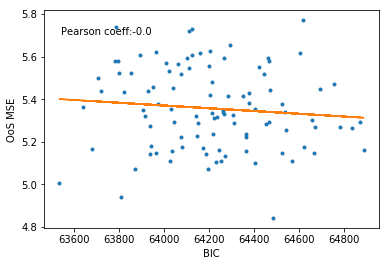

0.9909482395983314


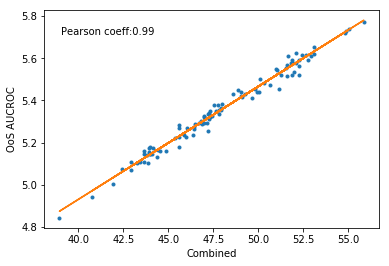

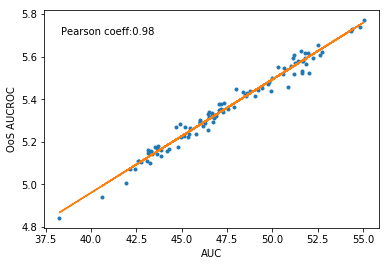

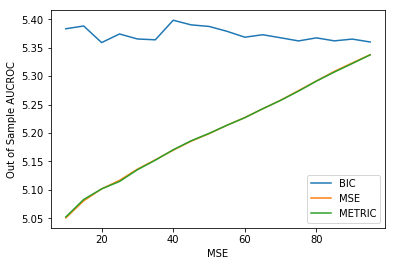

0.9909482395983314

In [15]:
from numpy.polynomial.polynomial import polyfit  
from scipy.stats import pearsonr
from pylab import text

def norm(a):
    return (a - np.min(a)) / a.ptp()
METRIC = norm(np.array(VIO)) + np.array(MSE)
n_low = 10
sorted_aus = [AUS for _,AUS in sorted(zip(VIO,AUS))]
print("Best by BIC = ", np.mean(sorted_aus[:n_low]))

sorted_aus = [AUS for _,AUS in sorted(zip(MSE,AUS))]
print("Best by AUC = ", np.mean(sorted_aus[:n_low]))


sorted_aus = [AUS for _,AUS in sorted(zip(METRIC,AUS))]
print("Best by MET = ", np.mean(sorted_aus[:n_low]))
print("Random = ", np.mean(AUS[:n_low]))
print(pearsonr(VIO,AUS)[0])
fig, ax = plt.subplots()
b,m = polyfit(VIO,AUS, 1)
ax.plot(VIO,AUS, '.')
text(0.05, 0.9,'Pearson coeff:' + str(pearsonr(VIO,AUS)[0])[0:4], ha='left', va='center', transform=ax.transAxes)
plt.plot(VIO, b + m * np.array(VIO), '-')
ax.set_xlabel("BIC")
ax.set_ylabel("OoS MSE")
fig.savefig('Ex4VIOVsAUS.pdf', bbox_inches='tight')
plt.show()



print(pearsonr(METRIC,AUS)[0])
fig, ax = plt.subplots()
b,m = polyfit(METRIC,AUS, 1)
ax.plot(METRIC,AUS, '.')
text(0.05, 0.9,'Pearson coeff:' + str(pearsonr(METRIC,AUS)[0])[0:4], ha='left', va='center', transform=ax.transAxes)
plt.plot(METRIC, b + m * np.array(METRIC), '-')
    #cax = ax.scatter(VIO,AUS)
ax.set_xlabel("Combined")
ax.set_ylabel("OoS AUCROC")
fig.savefig('Ex4ProposedVsAUS.pdf', bbox_inches='tight')
plt.show()


fig, ax = plt.subplots()
b,m = polyfit(MSE,AUS, 1)
text(0.05, 0.9,'Pearson coeff:' + str(pearsonr(MSE,AUS)[0])[0:4], ha='left', va='center', transform=ax.transAxes)
ax.plot(MSE,AUS, '.')
plt.plot(MSE, b + m * np.array(MSE), '-')
    #cax = ax.scatter(VIO,AUS)
ax.set_xlabel("AUC")
ax.set_ylabel("OoS AUCROC")
fig.savefig('Ex4MSEVsAUS.pdf', bbox_inches='tight')
plt.show()


MSE = np.array(MSE)

x = []
y1 = []
y2 = []
y3 = []
for split in range(10, len(AUS), 5):
    #print("******", split, "*******")
    sorted_aus = [AUS for _,AUS in sorted(zip(VIO,AUS))]
    sorted_mse = [MSE for _,MSE in sorted(zip(VIO,MSE))]

    low = []
    high = []
    low = sorted_aus[:split]
    high = sorted_aus[split:]

    x.append(split)
    
    
    #print("Low Violations = ", np.mean(low), "for", len(low))
    #print("High Violations = ", np.mean(high), "for", len(high))
    y1.append(np.mean(low)) 
    sorted_aus_by_mse = [AUS for _,AUS in sorted(zip(MSE,AUS))]
    low = sorted_aus_by_mse[:split]
    high = sorted_aus_by_mse[split:]
    #print("Low AUS by MSE = ", np.mean(low), "for", len(low))
    #print("High AUS by MSE = ", np.mean(high), "for", len(high))
    y2.append(np.mean(low))
    sorted_aus = [AUS for _,AUS in sorted(zip(METRIC,AUS))]
    sorted_mse = [MSE for _,MSE in sorted(zip(METRIC,MSE))]

    low = []
    high = []
    low = sorted_aus[:split]
    high = sorted_aus[split:]



    #print("Low Metric = ", np.mean(low), "for", len(low))
    #print("High Metric = ", np.mean(high), "for", len(high))
    y3.append(np.mean(low))
    

fig, ax = plt.subplots()

ax.plot(x,y1, '-', label = 'BIC')
ax.plot(x,y2, '-', label = 'MSE')
ax.plot(x,y3, '-', label = 'METRIC')
ax.legend()

ax.set_xlabel("MSE")
ax.set_ylabel("Out of Sample AUCROC")
plt.show()  
pearsonr(METRIC,AUS)[0]

In [7]:
model.predict(perturbed_df[inputs])

array([[-1.5679502 ],
       [ 7.250179  ],
       [-0.81391793],
       ...,
       [ 3.4196062 ],
       [ 9.027663  ],
       [-1.712926  ]], dtype=float32)

In [8]:
def gen_data(mean = 0, var = 0.1, SIZE = 20000):
    # set bmi to these values real world mean and standard deviation for a certain country.
    bmi = np.random.normal(20, var, SIZE)
    estrogen =  2*bmi +  np.random.normal(20,var, SIZE)
    age = np.random.normal(mean,var, SIZE)
    genes = 0.1 * age + 0.1 * estrogen +  np.random.normal(mean,var, SIZE)
    insomnia = estrogen +  np.random.normal(mean,var, SIZE)
    density = estrogen + genes + np.random.normal(mean,var, SIZE)
    cancer = 3 * density + np.random.normal(mean,var, SIZE)
    return pd.DataFrame({'bmi' : bmi,'density' : density, 'age' : age, 'cancer' : cancer, 'estrogen': estrogen, 'genes':genes, 'insomnia': insomnia})

def gen_data(mean = 0.4, var = 1.4, SIZE = 2000):
    # set bmi to these values real world mean and standard deviation for a certain country.
    bmi = np.random.normal(mean, var, SIZE)
    estrogen =  2*bmi +  np.random.normal(mean,var, SIZE)
    age = np.random.normal(mean,var, SIZE)
    genes = 1.1 * age +  estrogen +  np.random.normal(mean,var, SIZE)
    insomnia = estrogen +  np.random.normal(mean,var, SIZE)
    density = estrogen + genes + np.random.normal(mean,var, SIZE)
    cancer = density + np.random.normal(mean,var, SIZE)
    return pd.DataFrame({'bmi' : bmi,'density' : density, 'age' : age, 'cancer' : cancer, 'estrogen': estrogen, 'genes':genes, 'insomnia': insomnia})

def get_CG(df, tetrad):
    tetrad.run(algoId = 'fges', dfs = df, testId = 'sem-bic', scoreId = 'sem-bic', dataType = 'continuous',
           structurePrior = 1.0, samplePrior = 1.0, maxDegree = -1, maxPathLength = -1, 
           completeRuleSetUsed = False, faithfulnessAssumed = True, verbose = True)
    return tetrad.getTetradGraph()

df = gen_data()
get_CG(perturbed_df, tetrad)

Instance of edu.cmu.tetrad.graph.EdgeListGraphSingleConnections: Graph Nodes:
bmi;density;age;cancer;estrogen;genes;insomnia

Graph Edges:
1. age --> density
2. age --> genes
3. density --> cancer
4. density --> genes
5. estrogen --- bmi
6. estrogen --> density
7. estrogen --- insomnia

Graph Attributes:
BIC: -9748.799665

Graph Node Attributes:
BIC: [bmi: -1328.072399;density: -7698.697583;age: -1352.041438;cancer: -7769.691837;estrogen: -4572.470516;genes: -5385.427509;insomnia: -4946.981065]